#Predictive analysis, target feature: SFN treatment

**Load libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/eeg data/totall_df.csv'

In [ ]:
df = pd.read_csv(path)
df.tail()

,Example_names,F1_th/al,F1_th/beta,F1_th/gama,F2_th/al,F2_th/beta,F2_th/gama,T1_th/al,T1_th/beta,T1_th/gama,...,O1_th/gama,O2_th/al,O2_th/beta,O2_th/gama,Example,Day_time_h,Event_type,SFN_treat,Num_per_h,Dur_per_h
3322,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.376390,0.808605,14.442618,0.354407,0.646204,12.138190,0.413740,0.983833,23.487378,...,13.437017,0.360715,0.590758,7.511864,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3323,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.444862,0.883468,14.071816,0.413103,0.788776,13.421757,0.410607,0.911440,20.187075,...,14.771327,0.456566,0.861803,11.286298,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3324,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.471139,0.874434,11.718948,0.449249,0.813695,11.918224,0.431847,0.903160,16.261716,...,13.442645,0.508233,0.921530,9.931513,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3325,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.377731,0.824558,13.373822,0.348138,0.699460,12.694106,0.371347,0.898335,16.742484,...,13.953187,0.369664,0.693528,9.799755,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3326,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.534603,1.093385,19.617927,0.472650,0.777563,13.089325,0.474034,1.066304,24.289437,...,20.030298,0.517533,0.879643,13.251053,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0


In [ ]:
df.shape

(3327, 31)

**Final column manupulations**, dropping columns 'Example_names', 'Example', 'Dur_per_h'. To address multicollinearity with the target label, the columns 'Example_names' and 'Example' were excluded from the dataset. Additionally, the column 'Dur_per_h' was removed due to its redundancy with 'Num_per_h'. Importantly, 'Dur_per_h' did not demonstrate statistically significant changes in response to sulforaphane treatment across the 4-8 and 12-16 hour time intervals, rendering it less relevant for further analysis.

In [ ]:
# Final column manupulations, dropping columns 'Example_names', 'Example', 'Dur_per_h'.
df_new = df.drop(columns = ['Example_names', 'Example', 'Dur_per_h'])
df_new['Event_type'] = df_new['Event_type'].replace ('Seizure', 'SEIZURE')
import pandas as pd

column_to_move = 'B'
df_new = df_new[[col for col in df_new.columns if col !='SFN_treat'] + ['SFN_treat']]

print (df_new.columns)
df_new['Event_type'].nunique()

Index(['F1_th/al', 'F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta',
       'F2_th/gama', 'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al',
       'T2_th/beta', 'T2_th/gama', 'P1_th/al', 'P1_th/beta', 'P1_th/gama',
       'P2_th/al', 'P2_th/beta', 'P2_th/gama', 'O1_th/al', 'O1_th/beta',
       'O1_th/gama', 'O2_th/al', 'O2_th/beta', 'O2_th/gama', 'Day_time_h',
       'Event_type', 'Num_per_h', 'SFN_treat'],
      dtype='object')


3

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3327 entries, 0 to 3326
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   F1_th/al    3327 non-null   float64
 1   F1_th/beta  3327 non-null   float64
 2   F1_th/gama  3327 non-null   float64
 3   F2_th/al    3327 non-null   float64
 4   F2_th/beta  3327 non-null   float64
 5   F2_th/gama  3327 non-null   float64
 6   T1_th/al    3327 non-null   float64
 7   T1_th/beta  3327 non-null   float64
 8   T1_th/gama  3327 non-null   float64
 9   T2_th/al    3327 non-null   float64
 10  T2_th/beta  3327 non-null   float64
 11  T2_th/gama  3327 non-null   float64
 12  P1_th/al    3327 non-null   float64
 13  P1_th/beta  3327 non-null   float64
 14  P1_th/gama  3327 non-null   float64
 15  P2_th/al    3327 non-null   float64
 16  P2_th/beta  3327 non-null   float64
 17  P2_th/gama  3327 non-null   float64
 18  O1_th/al    3327 non-null   float64
 19  O1_th/beta  3327 non-null  

In [ ]:
# Define the feature groups: numerical and categorical
numerical_features = df_new.select_dtypes(include=['float64', 'int64']).columns
categorical_features = df_new.select_dtypes(include=['object']).columns
print ('Numerical features:')
print (numerical_features)
print ('Categorical features:')
print (categorical_features)

Numerical features:
Index(['F1_th/al', 'F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta',
       'F2_th/gama', 'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al',
       'T2_th/beta', 'T2_th/gama', 'P1_th/al', 'P1_th/beta', 'P1_th/gama',
       'P2_th/al', 'P2_th/beta', 'P2_th/gama', 'O1_th/al', 'O1_th/beta',
       'O1_th/gama', 'O2_th/al', 'O2_th/beta', 'O2_th/gama', 'Num_per_h'],
      dtype='object')
Categorical features:
Index(['Day_time_h', 'Event_type', 'SFN_treat'], dtype='object')


**Checking numerical data for multicollinearity**

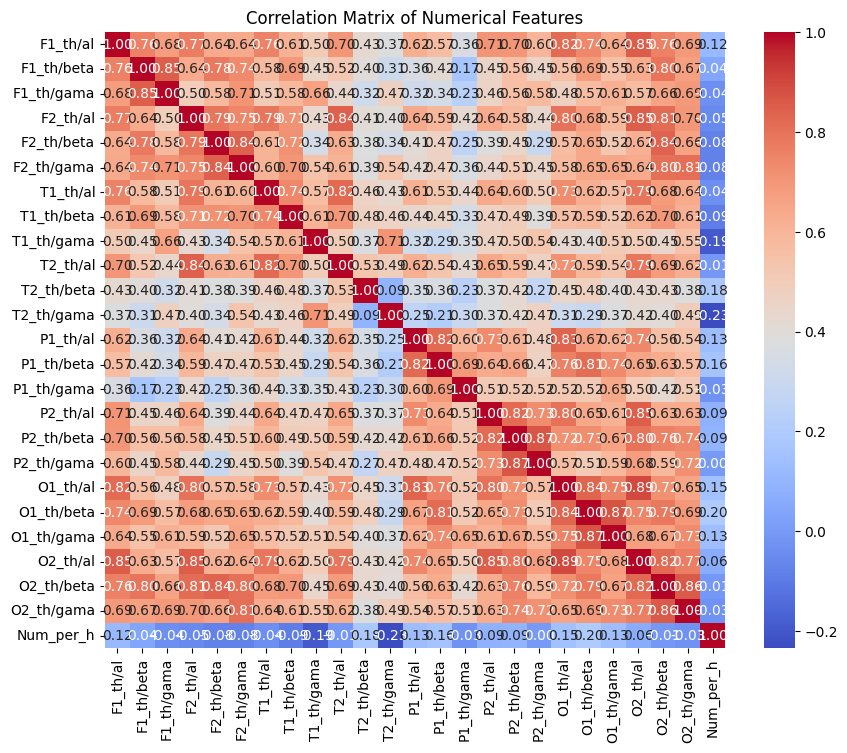

In [ ]:
correlation_matrix = df_new[numerical_features].corr()

# Візуалізація кореляційної матриці
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [ ]:
# Choose labels with correlation > 0.9
high_corr_pairs = np.where(correlation_matrix > 0.9)
high_corr_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j])
                   for i, j in zip(*high_corr_pairs) if i != j]
high_corr_pairs

[]

To examine the relationship between numerical features and a categorical variable, we used an ANOVA (for many categories). It allows us to check whether there are statistically significant differences in the mean values of numerical features for different categories of the target variable.

In [ ]:
import pandas as pd
from scipy.stats import f_oneway

results = []

for feature in numerical_features:
    groups = [df_new[df_new['SFN_treat'] == category][feature] for category in df_new['SFN_treat'].unique()]
    f_stat, p_value = f_oneway(*groups)

    results.append({
        'Feature': feature,
        'F-statistic': f_stat,
        'p-value': p_value
    })

results_df = pd.DataFrame(results)


results_df.to_excel('anova_results.xlsx', index=False)
results_df


,Feature,F-statistic,p-value
0,F1_th/al,0.005040,9.434088e-01
1,F1_th/beta,17.457339,3.013871e-05
2,F1_th/gama,105.017812,2.769382e-24
3,F2_th/al,524.230419,7.372366e-108
4,F2_th/beta,714.051753,1.137014e-142
5,F2_th/gama,258.485873,4.525636e-56
6,T1_th/al,94.693925,4.367288e-22
7,T1_th/beta,156.803051,3.472511e-35
8,T1_th/gama,239.632300,3.016957e-52
9,T2_th/al,175.564391,4.340097e-39


In [ ]:
# ANOVA test for many features and target feature
from scipy.stats import f_oneway

for feature in numerical_features:
    groups = [df_new[df_new['SFN_treat'] == category][feature] for category in df_new['SFN_treat'].unique()]
    f_stat, p_value = f_oneway(*groups)
    print(f"Feature: {feature}, F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")


Feature: F1_th/al, F-statistic: 0.01, p-value: 0.9434
Feature: F1_th/beta, F-statistic: 17.46, p-value: 0.0000
Feature: F1_th/gama, F-statistic: 105.02, p-value: 0.0000
Feature: F2_th/al, F-statistic: 524.23, p-value: 0.0000
Feature: F2_th/beta, F-statistic: 714.05, p-value: 0.0000
Feature: F2_th/gama, F-statistic: 258.49, p-value: 0.0000
Feature: T1_th/al, F-statistic: 94.69, p-value: 0.0000
Feature: T1_th/beta, F-statistic: 156.80, p-value: 0.0000
Feature: T1_th/gama, F-statistic: 239.63, p-value: 0.0000
Feature: T2_th/al, F-statistic: 175.56, p-value: 0.0000
Feature: T2_th/beta, F-statistic: 0.42, p-value: 0.5190
Feature: T2_th/gama, F-statistic: 104.23, p-value: 0.0000
Feature: P1_th/al, F-statistic: 78.47, p-value: 0.0000
Feature: P1_th/beta, F-statistic: 147.31, p-value: 0.0000
Feature: P1_th/gama, F-statistic: 48.38, p-value: 0.0000
Feature: P2_th/al, F-statistic: 22.30, p-value: 0.0000
Feature: P2_th/beta, F-statistic: 82.52, p-value: 0.0000
Feature: P2_th/gama, F-statistic: 35

**Conclusion:**

The majority of the features are statistically significant, as their p-value is less than 0.05, indicating that they are significant in the context of the categorical variable.
However, the variable F1_th/al was found to be insignificant (p=0.94) and can be excluded from further analysis.
For other significant features, it is recommended to take them into account in further stages of modelling and analysis.

**Checking relations between categorical and target features**

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency


# Create a contingency table for two independent variables and a dependent variable
contingency_table_1 = pd.crosstab([df_new['Day_time_h']], df_new['SFN_treat'])

# Conducting a chi-square test
chi2_stat_1, p_value_1, dof_1, expected_1 = chi2_contingency(contingency_table_1)

In [ ]:
# Create a contingency table for two independent variables and a dependent variable
contingency_table_2 = pd.crosstab([df_new['Event_type']], df_new['SFN_treat'])

# Conducting a chi-square test
chi2_stat_2, p_value_2, dof_2, expected_2 = chi2_contingency(contingency_table_2)

In [ ]:
# Creating DataFrame with results
results = pd.DataFrame({
    'Feature': ['Day_time_h', 'Event_type'],
    'Chi-Square Statistic': [chi2_stat_1, chi2_stat_2],
    'P-value': [p_value_1, p_value_2],
    'Degrees of Freedom': [dof_1, dof_2]
})

# Saving into Excel file
results.to_excel('chi_square_results.xlsx', index=False)
results

,Feature,Chi-Square Statistic,P-value,Degrees of Freedom
0,Day_time_h,0.000345,0.985174,1
1,Event_type,7.058590,0.029326,2


**Conclusion to 'Event_type':**
P-value = 0.0293, which is less than the significance level of 0.05, rejects the null hypothesis.
The null hypothesis states that there is no statistically significant relationship between the variables.
Since the p-value is less than 0.05, we can conclude that there is a statistically significant relationship between the variables 'Event_type' and 'SFN_treat'.
This means that changes in the values of one variable are likely associated with changes in the other variable.

**Conclusion to 'Day_time_h'**
P-value = 0.9852, which is much greater than the significance level of 0.05, means we fail to reject the null hypothesis.
Null Hypothesis: There is no statistically significant relationship between the two variables (they are independent).
Since the p-value is so large, we conclude that the two variables are likely independent of each other.
If a variable has a p-value greater than 0.05, this indicates that its effect on the outcome is not statistically significant enough and it can be excluded.
So, we may drop it from the model because its impact on the results is insignificant and it may only increase the complexity of the model without improving its performance.

In [ ]:
# By the results obrained we in addition can remove variables  'Day_time_h' and F1_th/al
df_finish = df_new.drop(columns = ['Day_time_h', 'T2_th/beta', 'F1_th/al'])
df_finish.columns

Index(['F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta', 'F2_th/gama',
       'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al', 'T2_th/gama',
       'P1_th/al', 'P1_th/beta', 'P1_th/gama', 'P2_th/al', 'P2_th/beta',
       'P2_th/gama', 'O1_th/al', 'O1_th/beta', 'O1_th/gama', 'O2_th/al',
       'O2_th/beta', 'O2_th/gama', 'Event_type', 'Num_per_h', 'SFN_treat'],
      dtype='object')

**Preparing target variable column, making pipeline**

In [ ]:
# Defining target column
X= df_finish.drop(columns = ['SFN_treat'])
y = df_finish['SFN_treat']

In [ ]:
# Setting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2661, 27), (666, 27), (2661,), (666,))

In [ ]:
numerical_attributes = X.select_dtypes(include=['float64', 'int64']).columns
categorical_attributes = X.select_dtypes(include=['object']).columns

In [ ]:
# Transforming target feature to binary format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Creating Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('scaler', StandardScaler())]), numerical_attributes),
        ('cat', Pipeline(steps=[('onehot', OneHotEncoder(sparse_output=False))]), categorical_attributes)
    ]
)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(objective='binary:logistic', max_depth=4, eta=0.1, n_estimators=100))
])

In [ ]:
# Model training

model.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta', 'F2_th/gama',
       'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al', 'T2_th/gama',
       'P1_th/al', 'P1_th/beta', 'P1_th/gama', 'P2_th/al', 'P2_th/beta',
       'P2_th/gama', 'O1_th/al', 'O1_th/beta', 'O1_...
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [94]:
import pickle

model_path = "xgb_model.pkl"
with open(model_path, 'wb') as model_file:
    pickle.dump(model, model_file)

**Model cross-validation**

In [ ]:
cv_scores = cross_val_score(model, X_train, y_train_encoded, cv=5, scoring='accuracy')

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean accuracy: {np.mean(cv_scores)}')
print(f'Standard deviation: {np.std(cv_scores)}')

Cross-validation scores: [0.95497186 0.95112782 0.96052632 0.94360902 0.95300752]
Mean accuracy: 0.9526485068205222
Standard deviation: 0.0055065685731842


In [ ]:
# Estimation by different metrics of accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='macro')
recall = recall_score(y_test_encoded, y_pred, average='macro')
f1 = f1_score(y_test_encoded, y_pred, average='macro')
report = classification_report(y_test_encoded, y_pred)

# Виведення результатів
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Classification Report:')
print(report)

Accuracy: 0.9714714714714715
Precision: 0.9716679896088902
Recall: 0.9716297024523555
F1 Score: 0.9714714071535661
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       337
           1       0.96      0.98      0.97       329

    accuracy                           0.97       666
   macro avg       0.97      0.97      0.97       666
weighted avg       0.97      0.97      0.97       666



In [ ]:
with open('classification_report_modell_treatment.txt', 'w') as file:
    file.write(report)

**Visualization Precision-Recall curve**

In [70]:
# Prediction possibility for train and test data
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

In [71]:
# Prediction possibility for train and test data
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

In [72]:
# Binarization of target train and test features
y_train_bin = label_binarize(y_train_encoded, classes=[0, 1])
y_test_bin = label_binarize(y_test_encoded, classes=[0, 1])

In [73]:
# Calculation Precision-Recall curves for train and test data
precision_train, recall_train, _ = precision_recall_curve(y_train_bin, y_train_prob)
precision_test, recall_test, _ = precision_recall_curve(y_test_bin, y_test_prob)

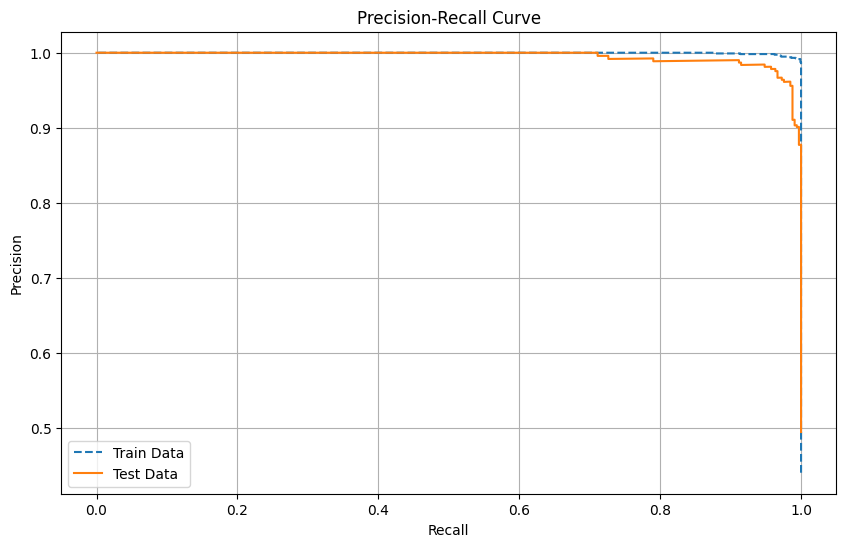

In [74]:
# Graph Precision-Recall
plt.figure(figsize=(10, 6))
plt.plot(recall_train, precision_train, label="Train Data", linestyle='--')
plt.plot(recall_test, precision_test, label="Test Data", linestyle='-')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.savefig('Precision-Recall Curve.png')
plt.show()

In [75]:
# Calculation ROC curves for train and test data
fpr_train, tpr_train, _ = roc_curve(y_train_bin, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test_bin, y_test_prob)

In [76]:
# Calculation AUC for train and test data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

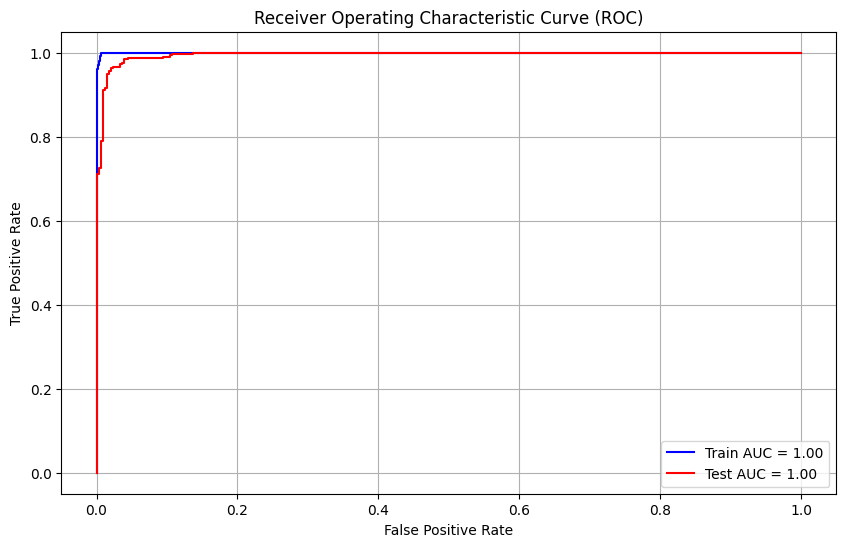

In [77]:
# ROC graph
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {roc_auc_train:.2f}", color='blue')
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {roc_auc_test:.2f}", color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('ROC Curve.png')
plt.show()

**Defining features' impotance**

In [79]:
importances = model.named_steps['classifier'].feature_importances_

# Getting all columns after transformation
categorical_columns_transformed = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_attributes)
all_feature_names = list(np.concatenate([numerical_attributes, categorical_columns_transformed]))
all_feature_names

['F1_th/beta',
 'F1_th/gama',
 'F2_th/al',
 'F2_th/beta',
 'F2_th/gama',
 'T1_th/al',
 'T1_th/beta',
 'T1_th/gama',
 'T2_th/al',
 'T2_th/gama',
 'P1_th/al',
 'P1_th/beta',
 'P1_th/gama',
 'P2_th/al',
 'P2_th/beta',
 'P2_th/gama',
 'O1_th/al',
 'O1_th/beta',
 'O1_th/gama',
 'O2_th/al',
 'O2_th/beta',
 'O2_th/gama',
 'Num_per_h',
 'Event_type_IED',
 'Event_type_MS',
 'Event_type_SEIZURE']

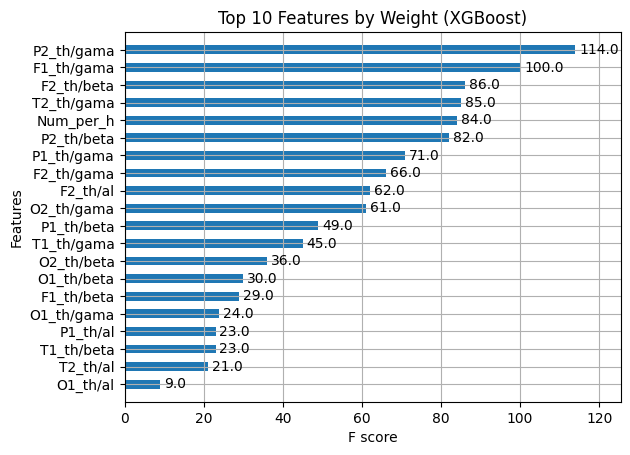

In [80]:
# Input all_feature_names into XGBoost model
model.named_steps['classifier'].get_booster().feature_names = all_feature_names

# Graph for features impotance
xgb.plot_importance(model.named_steps['classifier'],
                    importance_type='weight',
                    max_num_features=20,
                    height=0.5)

plt.title("Top 10 Features by Weight (XGBoost)")
plt.savefig('Top 10 Features by Weight (XGBoost).png')
plt.show()


#Clastering

**Clustering by frequency of epileptic episode**

In [81]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [82]:
# Getting datasets by the fact of treatment
df_treatment = df_finish[df_new['SFN_treat'] == 'SFN']
df_no_treatment = df_finish[df_new['SFN_treat'] == 'No_SFN']

In [83]:
print(df_treatment.columns)
print(df_no_treatment.columns)

Index(['F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta', 'F2_th/gama',
       'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al', 'T2_th/gama',
       'P1_th/al', 'P1_th/beta', 'P1_th/gama', 'P2_th/al', 'P2_th/beta',
       'P2_th/gama', 'O1_th/al', 'O1_th/beta', 'O1_th/gama', 'O2_th/al',
       'O2_th/beta', 'O2_th/gama', 'Event_type', 'Num_per_h', 'SFN_treat'],
      dtype='object')
Index(['F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta', 'F2_th/gama',
       'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al', 'T2_th/gama',
       'P1_th/al', 'P1_th/beta', 'P1_th/gama', 'P2_th/al', 'P2_th/beta',
       'P2_th/gama', 'O1_th/al', 'O1_th/beta', 'O1_th/gama', 'O2_th/al',
       'O2_th/beta', 'O2_th/gama', 'Event_type', 'Num_per_h', 'SFN_treat'],
      dtype='object')


In [84]:
# Select feature for clustering ('frequency of epileptic events')
features = ['Num_per_h']
X_treatment = df_treatment[features]
X_no_treatment = df_no_treatment[features]

In [85]:
# Data standartization
scaler = StandardScaler()
X_treatment_scaled = scaler.fit_transform(X_treatment)
X_no_treatment_scaled = scaler.fit_transform(X_no_treatment)

In [86]:
# Fuction for finding the optimal number of clasters (elbow method)
def find_optimal_clusters(data, max_k):
    distortions = []
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    return distortions

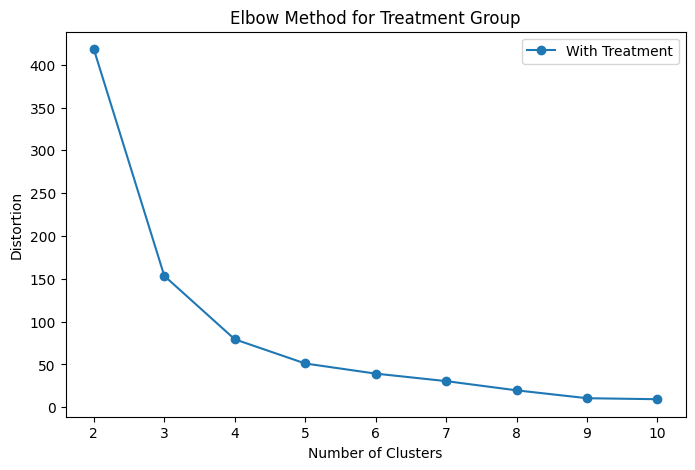

In [87]:
# Elbow graph for the group with SFN treatment
distortions_treatment = find_optimal_clusters(X_treatment_scaled, 10)
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), distortions_treatment, marker='o', label='With Treatment')
plt.title("Elbow Method for Treatment Group")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.legend()
plt.savefig('Elbow method results for clastering(modell by treatment)')
plt.show()

In [88]:
# Clasterization (k=3)
k = 3
kmeans_treatment = KMeans(n_clusters=k, random_state=42)
kmeans_no_treatment = KMeans(n_clusters=k, random_state=42)

clusters_treatment = kmeans_treatment.fit_predict(X_treatment_scaled)
clusters_no_treatment = kmeans_no_treatment.fit_predict(X_no_treatment_scaled)

In [89]:
# Adding claters to dataset
df_treatment['cluster'] = clusters_treatment
df_no_treatment['cluster'] = clusters_no_treatment

<ipython-input-89-a49172d64265>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treatment['cluster'] = clusters_treatment
<ipython-input-89-a49172d64265>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_treatment['cluster'] = clusters_no_treatment


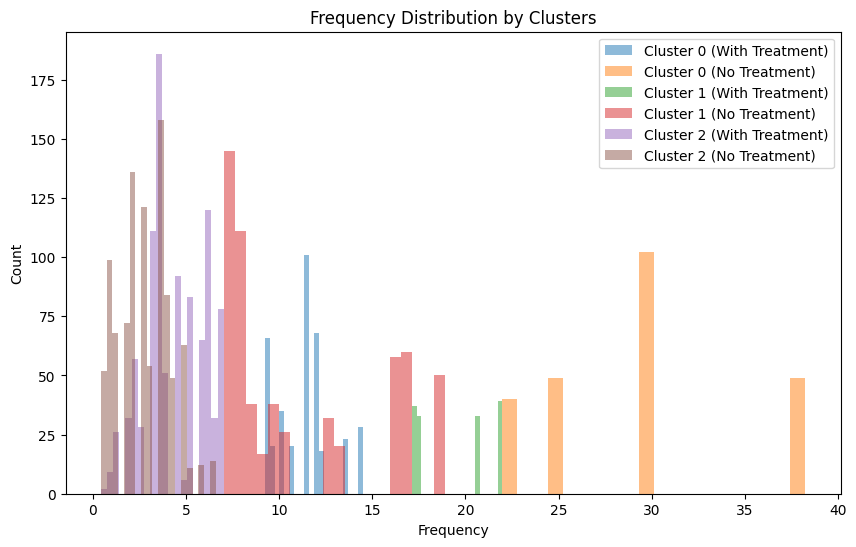

In [90]:
# Visualization clasters  by number of ep.events per hour
plt.figure(figsize=(10, 6))
for cluster in range(k):
    plt.hist(
        df_treatment[df_treatment['cluster'] == cluster]['Num_per_h'],
        alpha=0.5, bins=20, label=f'Cluster {cluster} (With Treatment)'
    )
    plt.hist(
        df_no_treatment[df_no_treatment['cluster'] == cluster]['Num_per_h'],
        alpha=0.5, bins=20, label=f'Cluster {cluster} (No Treatment)'
    )

plt.xlabel("Frequency")
plt.ylabel("Count")
plt.title("Frequency Distribution by Clusters")
plt.legend()
plt.savefig('Frequency_distribution_by_clusters.png')
plt.show()

In [91]:
# Обчислюємо середні значення для кожного кластеру з лікуванням і без
treatment_means = df_treatment.groupby('cluster')['Num_per_h'].mean()
no_treatment_means = df_no_treatment.groupby('cluster')['Num_per_h'].mean()

# Об'єднуємо ці значення в один DataFrame
cluster_means_df = pd.DataFrame({
    'With Treatment': treatment_means,
    'No Treatment': no_treatment_means
})

# Виводимо результат
print(cluster_means_df)


         With Treatment  No Treatment
cluster                              
0             11.266201     29.296703
1             19.390187     11.028904
2              4.331783      2.756438


In [92]:
cluster_means_df.to_csv('mean_values_by_claters_modell_treatment.csv')

**Summary:**

Some EEG records with a high event rate (cluster 0) moved to a group with a low or moderate seizure frequency after treatment. EEG records with a low-frequency event rate retained their low frequency even after treatment, although there may be a slight increase in the number of events in this group. This may indicate that the treatment helped to reduce the frequency of seizures in EEG records with a high frequency of event rate, possibly even moving them into the low- or intermediate-frequency groups.
